In [161]:
using Random
using Distributions
using Interpolations
using ProgressBars
using GLMakie

In [162]:
using LaTeXStrings

In [163]:
nk = 8
nkx = nk
nky = nk

nx = 512
ny = Int(512/nk)
Lx = 10
Ly = 10/nk
dx = Lx/nx
dy = Ly/ny

x = hcat(Array(-Lx/2+dx/2:dx:Lx/2-dx/2)...);
y = vcat(Array(-Ly/2+dy/2:dy:Ly/2-dy/2)...);
y = reshape(y, (size(y)...,1))

dt = 0.001;
T = 0.2;

In [164]:
κ = 1.e-2 #0.1 #1.
ψ0 = 1.0; #0.#1.0;

In [165]:
kx = nkx *(2π/Lx)
ky = nky *(2π/Lx)
ω = 2π/T

function ψfunc(x,y,t)
    return -ψ0 * sin.(kx*x .- ω*t).^2 .* sin.(ky*y).^2
end
function ufunc(x,y,t)
    return ψ0 * sin.(kx*x .- ω*t).^2 .* ( (ky * cos.(ky*y)) .* (2. * sin.(ky*y)) )
end
function vfunc(x,y,t)
    return -ψ0 * sin.(ky*y).^2 .* ( (kx * cos.(kx*x .- ω*t)) .* (2. * sin.(kx*x .- ω*t)) )
end

Pe = ψ0/κ
print("Pe = $Pe")

Pe = 100.0

In [166]:
function transport(c, uv)
    u = uv[1]
    v = uv[2]
    tendency = dt * (
        0.5*(circshift(u .* c, (0, 1)) .- circshift(u .* c, (0, -1))) / dx .+
        0.5*(circshift(v .* c, (1, 0)) .- circshift(v .* c, (-1, 0))) / dy
    )
    
    return tendency
end

function diffuse(c, κ)
    tendency = dt * κ * (
        (circshift(c, (0, 1)) .- (2. *c) .+ circshift(c, (0, -1))) / (dx^2) .+
        (circshift(c, (1, 0)) .- (2. *c) .+ circshift(c, (-1, 0))) / (dx^2)
    )
    
    return tendency
end

function integrate!(c, uv, κ)
    return c .+ transport(c, uv) .+ diffuse(c, κ)
end

integrate! (generic function with 1 method)

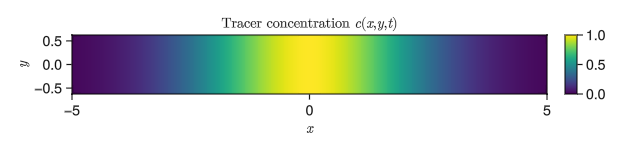

In [167]:
c0 = exp.(-((x/(0.25Lx)).^2)) .* ones(size(y)) #.+ (y/(0.25Ly)).^2))
c = copy(c0);

fig = Figure(size = (600+20, Int(600/nk)+75))
ax = Axis(
    fig[1, 1], limits=((-Lx/2, Lx/2), (-Ly/2, Ly/2)),
    xlabel=L"$x$", ylabel=L"$y$", title=L"Tracer concentration $c(x,y,t)$",
)
hm = heatmap!(ax, x[1,:], y[:,1], permutedims(c, (2,1)), colorrange=(0, 1))
Colorbar(fig[1, 2], hm)
fig

In [168]:
Niter_long = 300000
Niter_short = 300
t = 0:dt:(Niter_long-1)*dt
frame_frequency = 400;

In [169]:
dt*Niter_long

300.0

In [170]:
c = copy(c0);
c_diff = copy(c0);

c_save_short = c.*ones((1, 1, Niter_short));
c_diff_save_short = c_diff.*ones((1, 1, Niter_short));

c_save_long = c.*ones((1, 1, length(t)÷frame_frequency));
c_diff_save_long = c_diff.*ones((1, 1, length(t)÷frame_frequency));

In [171]:
for (iter, _) in enumerate(t)
    u,v = ufunc(x,y,t[iter]), vfunc(x,y,t[iter])
    c = integrate!(c, (u,v), κ)
    c_diff = integrate!(c_diff, (0*u,0*v), κ)
    if iter <= Niter_short
        c_save_short[:,:,iter] = c
        c_diff_save_short[:,:,iter] = c_diff
    end
    if iter%frame_frequency==0
        c_save_long[:,:,iter÷frame_frequency] = c
        c_diff_save_long[:,:,iter÷frame_frequency] = c_diff
    end
end

In [172]:
# Set initial conditions
t_snap = Observable(t[1])
c_snap = Observable(permutedims(c_save_short[:,:,1], (2,1)))
c_snap_mean = Observable(mean(c_save_short[:,:,1], dims=(1))[1,:])
c_diff_snap_mean = Observable(mean(c_diff_save_short[:,:,1], dims=(1))[1,:])

fig = Figure(size = (1000, 450))

ax1 = Axis(
    fig[1, 1], limits=((-Lx/2, Lx/2), (0, 1.05)),
    xlabel=L"$x$", ylabel=L"$\overline{\;c}$", title=L"Meridionally-averaged tracer concentration $\overline{\;c}(x,t)$",
)
lines!(ax1, x[1,:], mean(c0, dims=(1))[1,:], label=L"$\overline{\;c}(x,t=0)$ (Initial condition)")
lines!(ax1, x[1,:], c_snap_mean, label="Advection and diffusion")
lines!(ax1, x[1,:], c_diff_snap_mean, label="Diffusion only")
leg = axislegend(ax1)

ax2 = Axis(
    fig[2, 1], limits=((-Lx/2, Lx/2), (-Ly/2, Ly/2)), height=700/8, width=700,
    xlabel=L"$x$", ylabel=L"$y$", title=L"Tracer concentration $c(x,y,t)$",
)
hm = heatmap!(ax2, x[1,:], y[:,1], c_snap, colorrange=(0, 1))
Colorbar(fig[2, 2], hm, label=L"$c$")

text!(ax1, @lift("t = $(round($t_snap, digits = 3))"), position=(-4.85,0.875), space = :data)

fig

record(fig, "../movies/Lecture05_turbulent_diffusion_short.mp4", 1:length(c_save_short[1,1,:]);
    framerate = 30) do iter
    t_snap[] = t[iter]
    c_snap[] = permutedims(c_save_short[:,:,iter], (2,1))
    c_snap_mean[] = mean(c_save_short[:,:,iter], dims=(1))[1,:]
    c_diff_snap_mean[] = mean(c_diff_save_short[:,:,iter], dims=(1))[1,:]
end

"../movies/Lecture05_turbulent_diffusion_short.mp4"

In [173]:
# Set initial conditions
t_snap = Observable(t[1])
c_snap = Observable(permutedims(c_save_long[:,:,1], (2,1)))
c_snap_mean = Observable(mean(c_save_long[:,:,1], dims=(1))[1,:])
c_diff_snap_mean = Observable(mean(c_diff_save_long[:,:,1], dims=(1))[1,:])

fig = Figure(size = (1000, 450))

ax1 = Axis(
    fig[1, 1], limits=((-Lx/2, Lx/2), (0, 1.05)),
    xlabel=L"$x$", ylabel=L"$\overline{\;c}$", title=L"Meridionally-averaged tracer concentration $\overline{\;c}(x,t)$",
)
lines!(ax1, x[1,:], mean(c0, dims=(1))[1,:], label=L"$\overline{\;c}(x,t=0)$ (Initial condition)")
lines!(ax1, x[1,:], c_snap_mean, label="Advection and diffusion")
lines!(ax1, x[1,:], c_diff_snap_mean, label="Diffusion only")
leg = axislegend(ax1)

ax2 = Axis(
    fig[2, 1], limits=((-Lx/2, Lx/2), (-Ly/2, Ly/2)), height=700/8, width=700,
    xlabel=L"$x$", ylabel=L"$y$", title=L"Tracer concentration $c(x,y,t)$",
)
hm = heatmap!(ax2, x[1,:], y[:,1], c_snap, colorrange=(0, 1))
Colorbar(fig[2, 2], hm, label=L"$c$")

text!(ax1, @lift("t = $(round($t_snap, digits = 3))"), position=(-4.85,0.875), space = :data)

fig

record(fig, "../movies/Lecture05_turbulent_diffusion_long.mp4", 1:length(c_save_long[1,1,:]);
    framerate = 30) do iter
    t_snap[] = t[iter*frame_frequency]
    c_snap[] = permutedims(c_save_long[:,:,iter], (2,1))
    c_snap_mean[] = mean(c_save_long[:,:,iter], dims=(1))[1,:]
    c_diff_snap_mean[] = mean(c_diff_save_long[:,:,iter], dims=(1))[1,:]
end

"../movies/Lecture05_turbulent_diffusion_long.mp4"